__Goal__: Test inversion

    After simulate a source galaxy and deflect it, it's time to test the inversion!
    
We do that using two different approaches:
    1. Using the MGE decomposition, as we do in the simulation
    2. Using the pseudo ellpitical NFW analytical model.

In [1]:
import autolens as al
import autolens.plot as aplt
import numpy as np

from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u

data_folder = "/home/carlos/Documents/GitHub/Master-Degree/Autolens tests/autolens_workspace/Test_8/Simulation_Data/"

In [2]:
#Reading MGE inputs
surf_lum, sigma_lum, qobs_lum = np.loadtxt("Input/JAM_Input.txt", unpack=True)        #MGE decomposition
surf_dm, sigma_dm , qobs_dm   = np.loadtxt("Input/eNFW.txt", unpack=True)             #DM component

### Input parameters
Defining same inputs used for Jampy simulation (you can find it in __input_parameters.txt__, inside Simulation Data folder). And the necessary inputs for Autolens. 

In [3]:
z_l     = 0.299                                                         #Redshift of lens
z_s     = 4.100                                                         #Redshift of source
D_l     = cosmo.angular_diameter_distance(z_l).value                    #Distance to Lens [Mpc] 
mbh     = 1e9                                                           #mass of black hole [log10(M_sun)]
beta    = np.full_like(surf_lum, 0.00)                                  #anisotropy [ad]
inc     = 90                                                            #inclination [deg]
inc_rad = np.radians(inc)
qinc    = np.sqrt(np.min(qobs_lum)**2 - 
                    (1 - np.min(qobs_lum)**2)/np.tan(inc_rad)**2)       #Deprojected axial ratio for inclination
qDM     = np.sqrt( qobs_dm[0]**2 - np.cos(inc_rad)**2)/np.sin(inc_rad)  #Deprojected DM axial ratio
kappa_s = 0.075                                                         #kappa_s of DM profile
r_s     = 18.0                                                          #Scale radius [arcsec]
ml      = 7.20                                                          #mass to light ratio
phi_shear = 88                                                          #Inclination of external shear [deg]
mag_shear = 0.02                                                        #magnitude of shear
shear_comp = al.convert.shear_elliptical_comps_from(magnitude=mag_shear, phi=phi_shear) #external shear

pixsize = 0.2    #MUSE pixel size
print("qInc: %.4f" %qinc)
print("qDM: %.4f"  %qDM)

qInc: 0.5500
qDM: 0.8500


### Reading Data

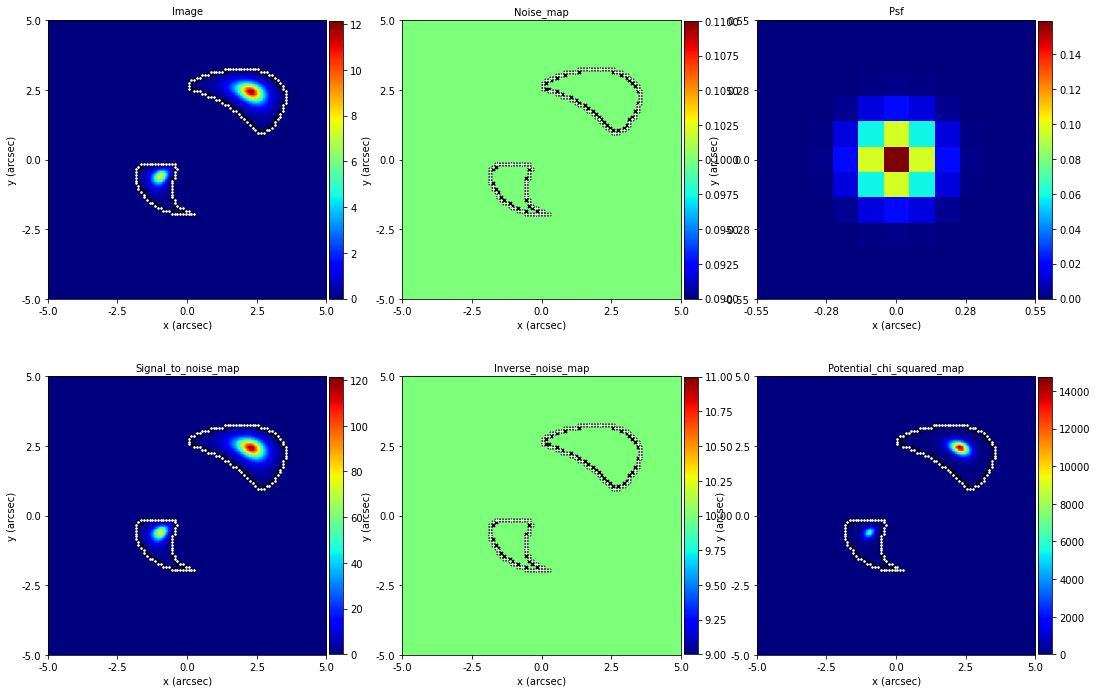

In [4]:
imaging = al.Imaging.from_fits(
        image_path=f"{data_folder}/image.fits",
        noise_map_path=f"{data_folder}/noise_map.fits",
        psf_path=f"{data_folder}/psf.fits",
        pixel_scales=0.1,
    )

mask        = al.Mask.from_fits( file_path=f"{data_folder}/new_mask.fits", hdu=1, 
                                    pixel_scales=imaging.pixel_scales)

masked_image = al.MaskedImaging(imaging=imaging, mask=mask, inversion_uses_border=True)     #Masked image


aplt.Imaging.subplot_imaging(
    imaging=imaging, mask=mask, include=aplt.Include(border=True),                         #Plot
)

In [5]:
masked_image.grid.shape

(747, 2)

## Starting model only MGE
Here we define the lens mass profile. This frist model uses the MGE eNFW decompostion.

In [6]:
#MGE mass profile

#Initializing
mass_profile = al.mp.MGE()
ell_comp = al.convert.elliptical_comps_from(axis_ratio=qobs_dm[0], phi=0.0)
eNFW = al.mp.dark_mass_profiles.EllipticalNFW(kappa_s=kappa_s,elliptical_comps=ell_comp,scale_radius=r_s)

#Components
mass_profile.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml,
                       mbh=mbh)
mass_profile.Analytic_Model(eNFW)

#Grid
#mass_profile.MGE_Grid_parameters(masked_image.grid)

#Lens galaxy
lens_galaxy = al.Galaxy(
    redshift=z_l,
    mass=mass_profile,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

## Inversion with Fit Tracer

Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model


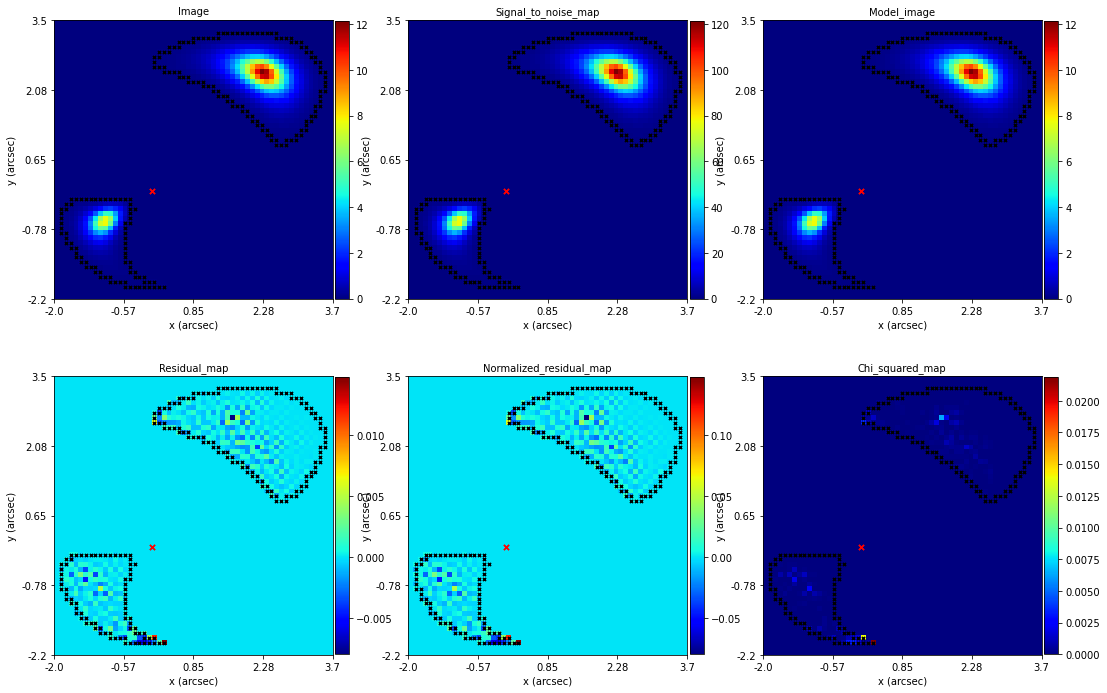

Log Likelihood with Regularization: 1033.5168518416956
Log Likelihood: 1033.5168755932912
Log Evidence: -4117.8799617506365
Noise Normalization -2067.1679603253233


In [15]:
source_galaxy = al.Galaxy(
    redshift=z_s,
    pixelization=al.pix.Rectangular(shape=(40, 40)),
    regularization=al.reg.Constant(coefficient=0.0),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

fit = al.FitImaging(masked_imaging=masked_image, tracer=tracer)

aplt.FitImaging.subplot_fit_imaging(fit=fit, include=aplt.Include(mask=True))
print("Log Likelihood with Regularization:", fit.log_likelihood_with_regularization)
print("Log Likelihood:", fit.log_likelihood)
print("Log Evidence:", fit.log_evidence)
print("Noise Normalization", fit.noise_normalization)

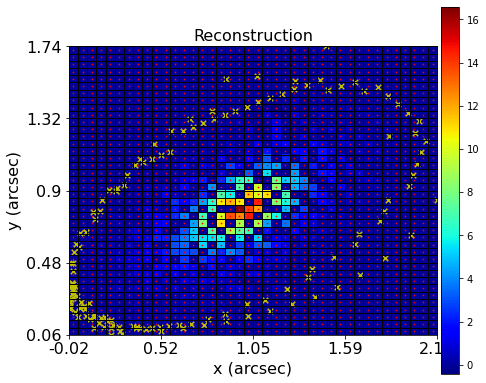

In [16]:
aplt.Inversion.reconstruction(fit.inversion)

 ----------------------------------------------------------------------------------------------------------- 

Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model


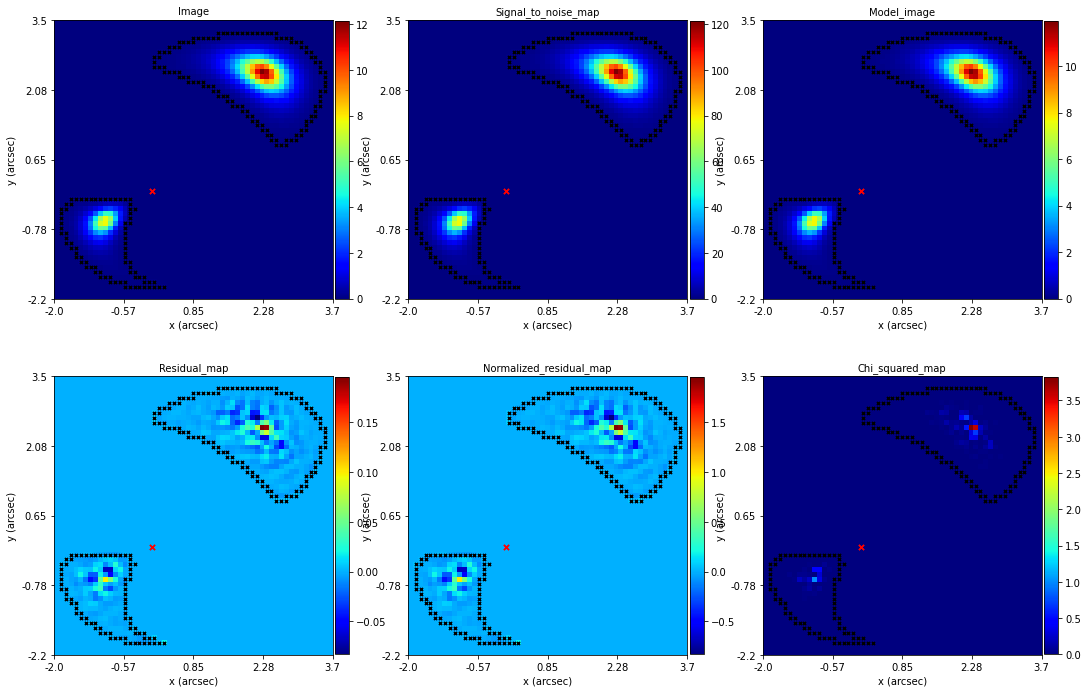

Log Likelihood with Regularization: 691.7504209123465
Log Likelihood: 1023.4218977269672
Log Evidence: 403.788716341287
Noise Normalization -2067.1679603253233


In [22]:
source_galaxy = al.Galaxy(
    redshift=z_s,
    pixelization=al.pix.Rectangular(shape=(40, 40)),
    regularization=al.reg.Constant(coefficient=1.0),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

fit = al.FitImaging(masked_imaging=masked_image, tracer=tracer)

aplt.FitImaging.subplot_fit_imaging(fit=fit, include=aplt.Include(mask=True))
print("Log Likelihood with Regularization:", fit.log_likelihood_with_regularization)
print("Log Likelihood:", fit.log_likelihood)
print("Log Evidence:", fit.log_evidence)
print("Noise Normalization", fit.noise_normalization)

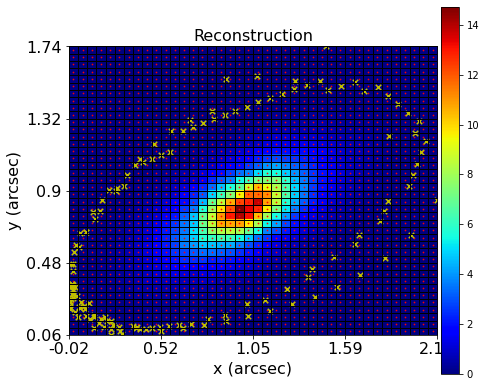

In [23]:
aplt.Inversion.reconstruction(fit.inversion)